# Utilização da biblioteca pvlib para calcular a irradiância solar com base na localização, 
# posição do Sol e condições atmosféricas.

☀ Por que a curva tem formato de U?
Posição do Sol no Céu

Pela manhã, o Sol nasce e sua altura no céu (ângulo de elevação solar) começa baixa. Isso significa que a quantidade de irradiância direta normal (DNI - Direct Normal Irradiance) é pequena.
Ao longo do dia, o Sol sobe até atingir o meio-dia solar, quando sua altura é máxima e, consequentemente, a irradiância direta é maior.
Depois do meio-dia, o Sol começa a descer no horizonte, reduzindo novamente a irradiância, até o pôr do sol.
Modelo de Céu Limpo (Clear Sky Model)

Você está usando o modelo get_clearsky(), que estima a irradiância assumindo ausência de nuvens e atmosfera idealizada.
Esse modelo gera uma curva simétrica, pois só depende da geometria do Sol no céu e não considera fenômenos como dispersão atmosférica e variações climáticas diárias.
Efeito da Atmosfera

Pela manhã e no final da tarde, a luz do Sol percorre um caminho maior na atmosfera (ângulo de incidência baixo), o que causa maior absorção e espalhamento da luz, reduzindo a irradiância medida.
Ao meio-dia solar, quando o Sol está mais alto, sua luz atravessa uma menor quantidade de atmosfera, resultando em irradiância máxima.

In [1]:
import pvlib
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# Definir a localização (latitude, longitude, fuso horário)

In [2]:
location = pvlib.location.Location(latitude=40.0, longitude=-105.0, tz='Etc/GMT+7')

# Definir intervalo de tempo

In [3]:
times = pd.date_range(start='2024-01-01', end='2024-01-02', freq='1H', tz=location.tz)

In [4]:
solar_position = location.get_solarposition(times)

                           apparent_zenith      zenith  apparent_elevation  \
2024-01-01 00:00:00-07:00       163.022877  163.022877          -73.022877   
2024-01-01 01:00:00-07:00       159.222187  159.222187          -69.222187   
2024-01-01 02:00:00-07:00       150.107214  150.107214          -60.107214   
2024-01-01 03:00:00-07:00       139.203643  139.203643          -49.203643   
2024-01-01 04:00:00-07:00       127.783191  127.783191          -37.783191   
2024-01-01 05:00:00-07:00       116.340324  116.340324          -26.340324   
2024-01-01 06:00:00-07:00       105.166240  105.166240          -15.166240   
2024-01-01 07:00:00-07:00        94.521211   94.521211           -4.521211   
2024-01-01 08:00:00-07:00        84.581730   84.708198            5.418270   
2024-01-01 09:00:00-07:00        76.065261   76.119394           13.934739   
2024-01-01 10:00:00-07:00        69.223934   69.259941           20.776066   
2024-01-01 11:00:00-07:00        64.685031   64.714056          

In [173]:
class Zone: 
    def __init__(self, latitude, longitude, timezone): 
        self.latitude = latitude
        self.longitude =longitude
        self.timezone = timezone

        self.location: any = None

    def calcLocation(self):
        self.location = pvlib.location.Location(self.latitude, self.longitude, self.timezone)
        return self.location


class Amostras: 
    def __init__(self): 
        self.amostras: Zone = []

        self.date_init=  ""
        self.date_final= ""

        self.date_init_no_cme = ""
        self.date_final_no_cme = ""

        self.date_init_no_cme_2 = ""
        self.date_final_no_cme_2 = ""

    def addAmostra(self, zone: Zone):
        self.amostras.append(zone) 

    def setupCmeDates(self, init, final): 
        self.date_init = init 
        self.date_final = final

    def setupNoCmeDates(self, init, final): 
        self.date_init_no_cme = init 
        self.date_final_no_cme = final

    def setupSecondaryNoCmeDates(self, init, final): 
        self.date_init_no_cme_2 = init 
        self.date_final_no_cme_2 = final



In [189]:
def calcSunCurves(campo: Amostras):
    for i, amostra in enumerate(campo.amostras): 
        location = amostra.calcLocation()

        # Datas e horários para os dois dias
        times_cme = pd.date_range(start= campo.date_init, end=campo.date_final, freq="2min", tz=amostra.timezone)  # Dia com CME
        times_no_cme = pd.date_range(start=campo.date_init_no_cme, end=campo.date_final_no_cme, freq="2min", tz=amostra.timezone)  # Dia sem CME
        times_no_cme2 = pd.date_range(start=campo.date_init_no_cme_2, end=campo.date_final_no_cme_2, freq="2min", tz=amostra.timezone)  # Dia sem CME

        # Dados de irradiância para o dia com CME
        clearsky_cme = location.get_clearsky(times_cme)  # Modelo de céu limpo
        direct_irradiance_cme = clearsky_cme['dni']

        # Dados de irradiância para o dia sem CME
        clearsky_no_cme = location.get_clearsky(times_no_cme)  # Modelo de céu limpo
        direct_irradiance_no_cme = clearsky_no_cme['dni']

        # Dados de irradiância para o dia sem CME
        clearsky_no_cme2 = location.get_clearsky(times_no_cme2)  # Modelo de céu limpo
        direct_irradiance_no_cme2 = clearsky_no_cme2['dni']

        # Criar o gráfico lado a lado
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

        axs[0].plot(times_cme, direct_irradiance_no_cme, label='Dia sem CME:' + campo.date_init_no_cme, color='orange')
        axs[0].plot(times_cme, direct_irradiance_no_cme2, label='Dia sem CME:' + campo.date_init_no_cme_2, color='pink')

        axs[0].plot(times_cme, direct_irradiance_cme, label='Dia com CME:' + campo.date_init, color='blue')

        axs[0].set_xlabel('Data e Hora')
        axs[0].set_ylabel('Irradiância Direta (W/m²)')
        axs[0].set_title('Irradiância Direta:::' + amostra.timezone)
        axs[0].legend()
        axs[0].grid(True)
        axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=amostra.timezone))
        axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=2))

        # Gráfico 2: Dia sem CME (2020-01-02)
        ruidos = direct_irradiance_no_cme.values - direct_irradiance_cme.values 

        # Rotacionar as labels do eixo x para melhor visualização
        axs[1].plot(times_no_cme, ruidos, label='Ruído', color='orange')
        axs[1].set_xlabel('Data e Hora')
        axs[1].set_ylabel('Irradiância Direta (W/m²)')
        axs[1].set_title('Comparação de Irradiância Direta: Dias sem CME')
        axs[1].legend()
        axs[1].grid(True)
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=amostra.timezone))
        axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=2))

        # Ajustar layout para evitar sobreposição
        plt.tight_layout()

        # Exibir os gráficos
        plt.show()


# Comparando entre dois dias sem CME

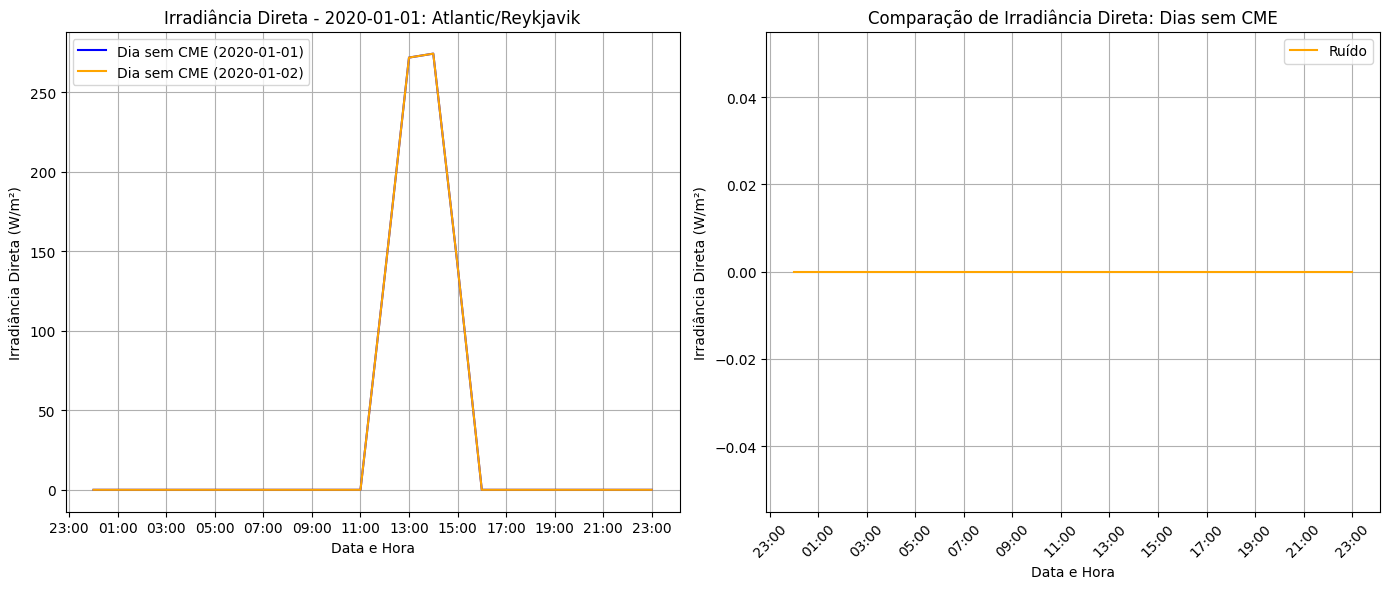

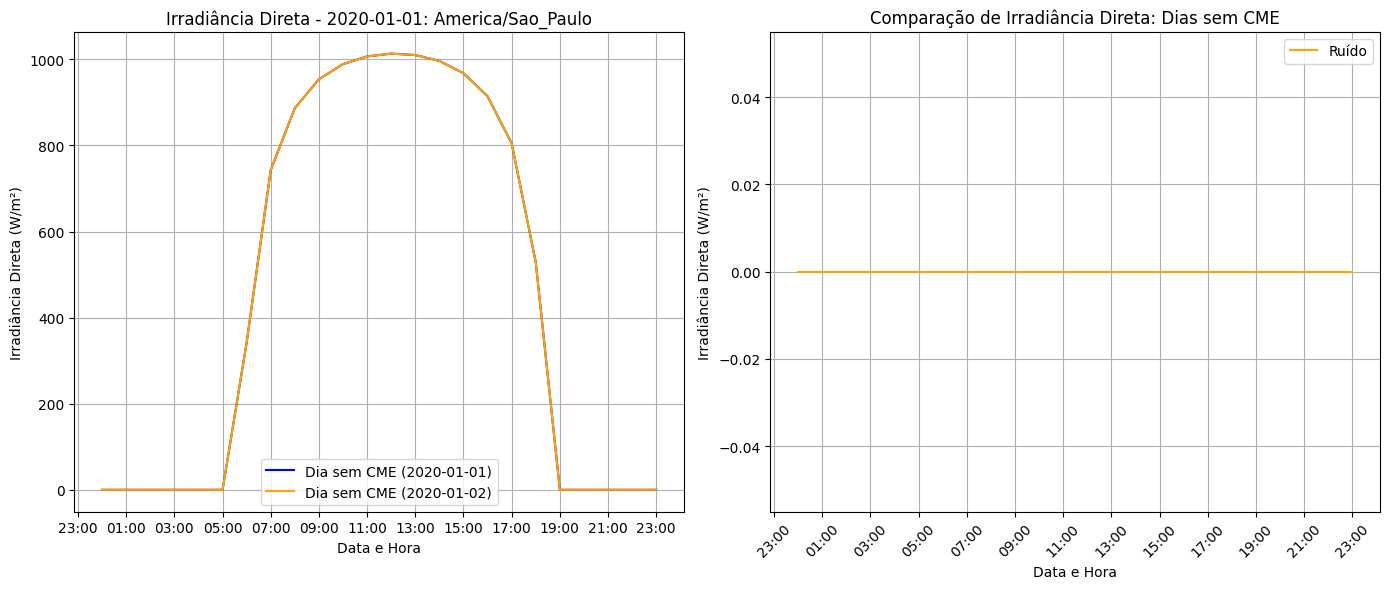

In [159]:
# Localização e dados meteorológicos

amostra_1 = Zone(64.13, -21.90, 'Atlantic/Reykjavik')
amostra_2 = Zone(-23.55, -46.63, 'America/Sao_Paulo')

campo = Amostras()
campo.addAmostra(amostra_1)
campo.addAmostra(amostra_2)

for i, amostra in enumerate(campo.amostras): 
    location = amostra.calcLocation()

    # Datas e horários para os dois dias
    times_no_cme = pd.date_range(start="2020-01-01", end="2020-01-01 23:59", freq="1H", tz=amostra.timezone)  # Dia sem CME
    times_no_cme2 = pd.date_range(start="2020-01-02", end="2020-01-02 23:59", freq="1H", tz=amostra.timezone)  # Dia sem CME

    # Dados de irradiância para o dia sem CME
    clearsky_no_cme = location.get_clearsky(times_no_cme)  # Modelo de céu limpo
    direct_irradiance_no_cme = clearsky_no_cme['dni']

    # Dados de irradiância para o dia sem CME
    clearsky_no_cme2 = location.get_clearsky(times_no_cme2)  # Modelo de céu limpo
    direct_irradiance_no_cme2 = clearsky_no_cme['dni']

    # Criar o gráfico lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

    # Gráfico 1: Dia sem CME (2020-01-01)
    axs[0].plot(times_no_cme, direct_irradiance_no_cme, label='Dia sem CME (2020-01-01)', color='blue')
    axs[0].plot(times_no_cme, direct_irradiance_no_cme2, label='Dia sem CME (2020-01-02)', color='orange')
    axs[0].set_xlabel('Data e Hora')
    axs[0].set_ylabel('Irradiância Direta (W/m²)')
    axs[0].set_title('Irradiância Direta - 2020-01-01: ' + amostra.timezone)
    axs[0].legend()
    axs[0].grid(True)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=amostra.timezone))
    axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=2))

    # Gráfico 2: Dia sem CME (2020-01-02)
    ruidos = direct_irradiance_no_cme2.values - direct_irradiance_no_cme.values 

    # Formatar o eixo x com horas no horário de Brasília
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=amostra.timezone))  # Formato de hora:minuto
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Marcações a cada 2 horas

    # Rotacionar as labels do eixo x para melhor visualização
    plt.xticks(rotation=45)

    axs[1].plot(times_no_cme, ruidos, label='Ruído', color='orange')
    axs[1].set_xlabel('Data e Hora')
    axs[1].set_ylabel('Irradiância Direta (W/m²)')
    axs[1].set_title('Comparação de Irradiância Direta: Dias sem CME')
    axs[1].legend()
    axs[1].grid(True)

    # Ajustar layout para evitar sobreposição
    plt.tight_layout()

    # Exibir os gráficos
    plt.show()

# Demonstrações

# CME 04/01/2025 | Alta

Em 4 de janeiro de 2025, o Sol emitiu uma erupção solar de classe X1.8, uma das mais intensas, com pico às 7h48 ET (10h48 GMT). 
BLOG DA NASA

As erupções solares de classe X podem liberar aproximadamente 10^26 a 10^27 joules de energia. No entanto, a maior parte dessa energia é dispersa no espaço, com apenas uma pequena fração atingindo a Terra. A intensidade e os efeitos dessa energia dependem de fatores como a direção da ejeção e a interação com o campo magnético terrestre.

Para informações mais detalhadas sobre a energia específica dessa erupção e seus impactos, é recomendável consultar fontes especializadas, como o Centro de Previsão do Clima Espacial da NOAA ou o Instituto Nacional de Pesquisas Espaciais (INPE).

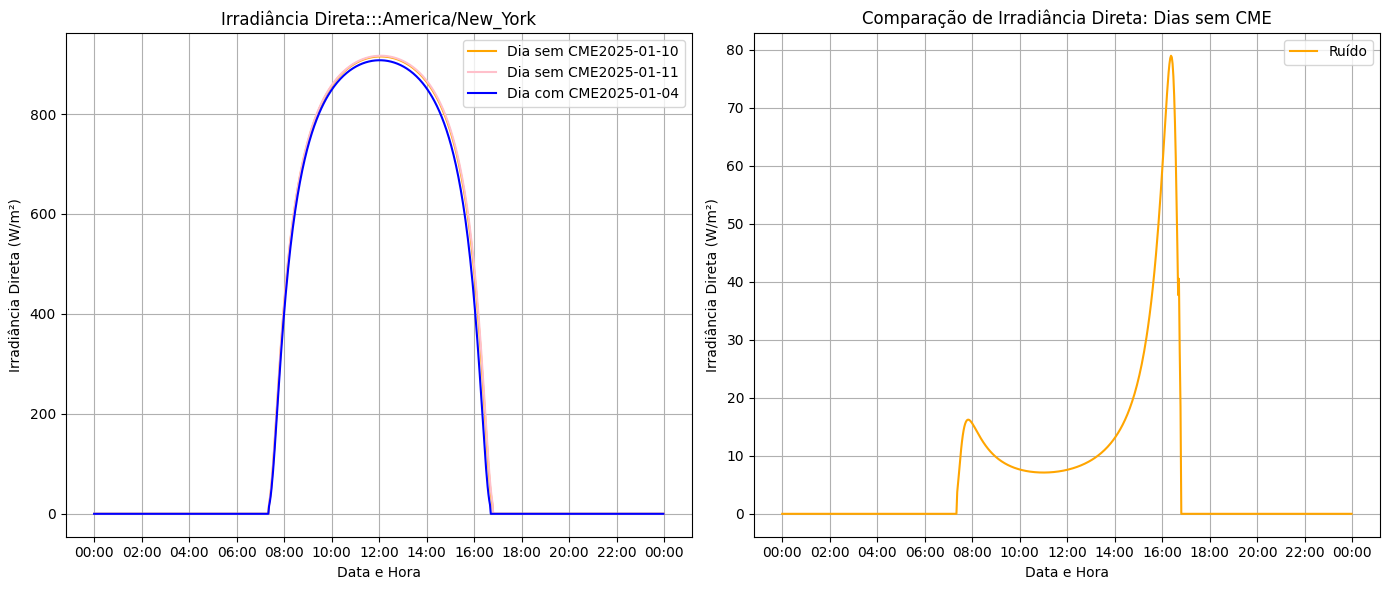

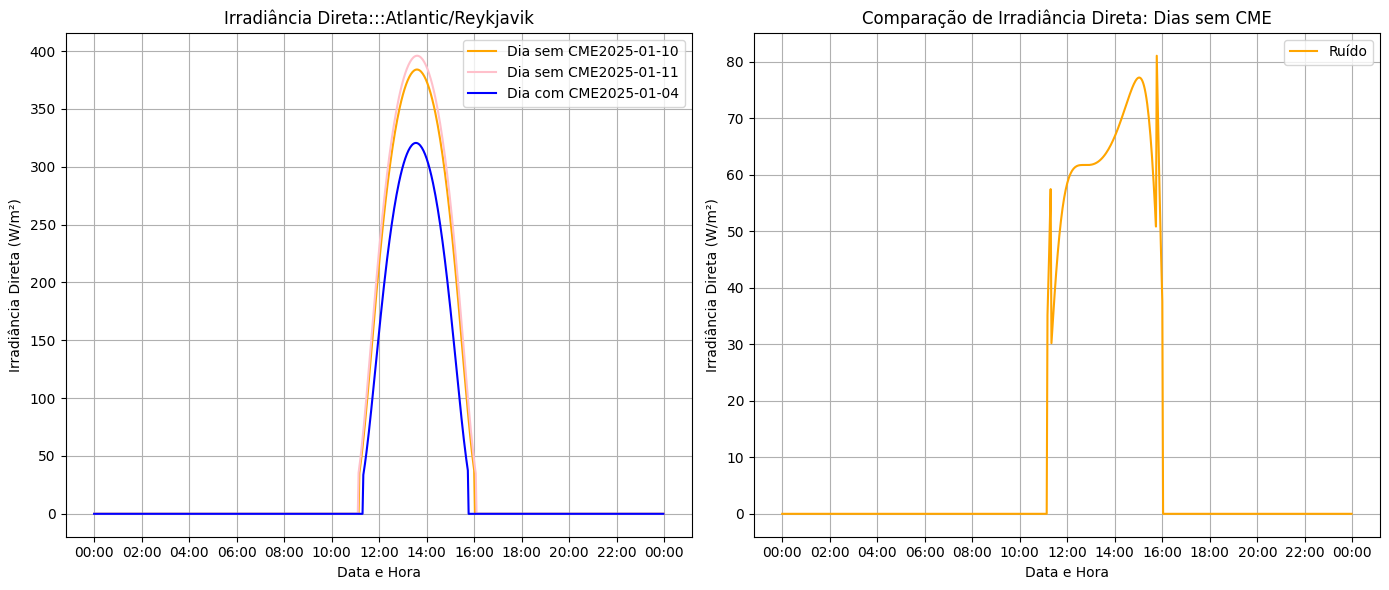

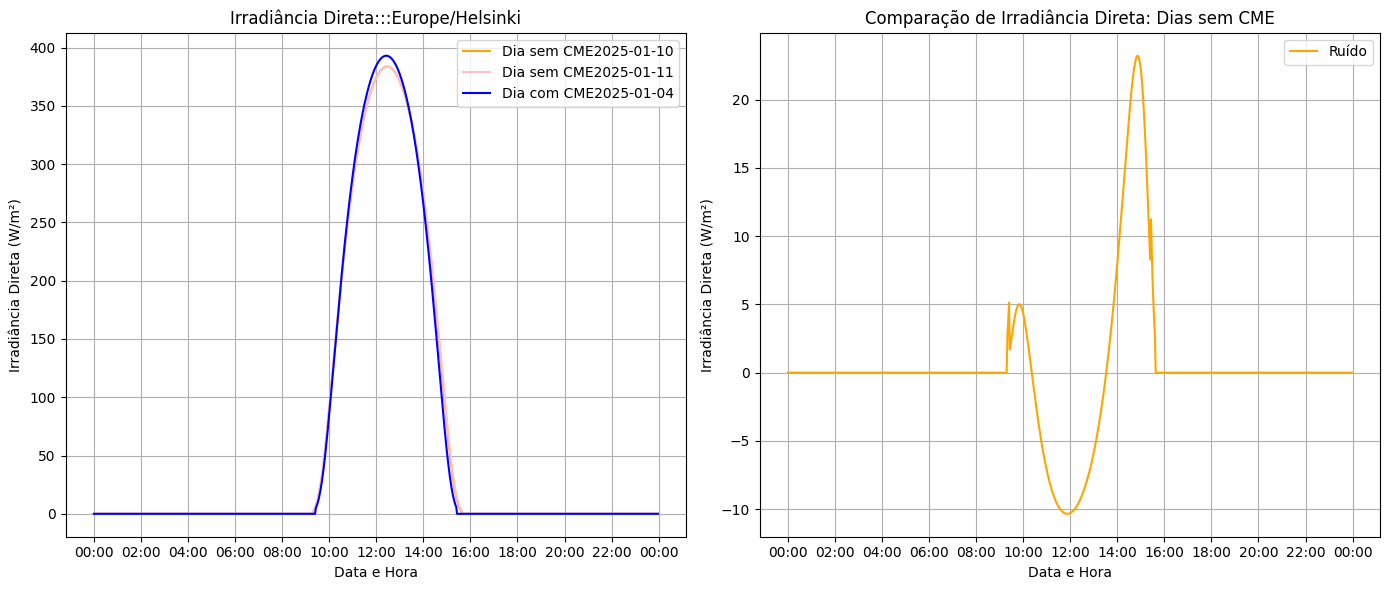

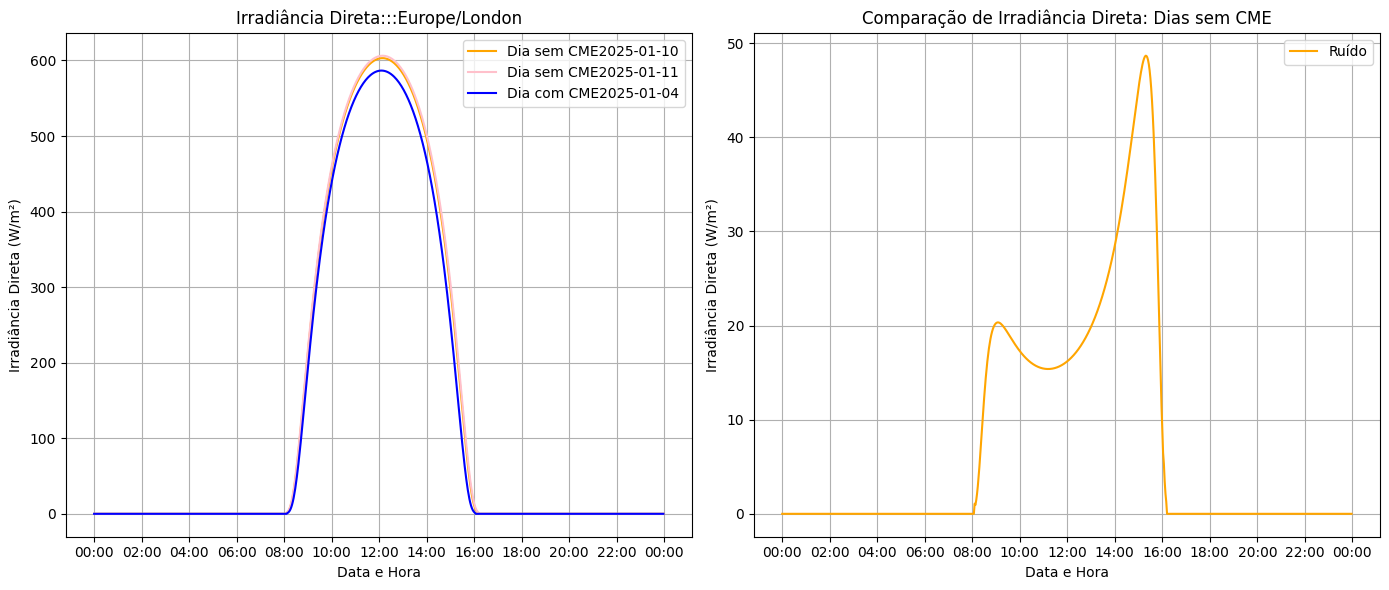

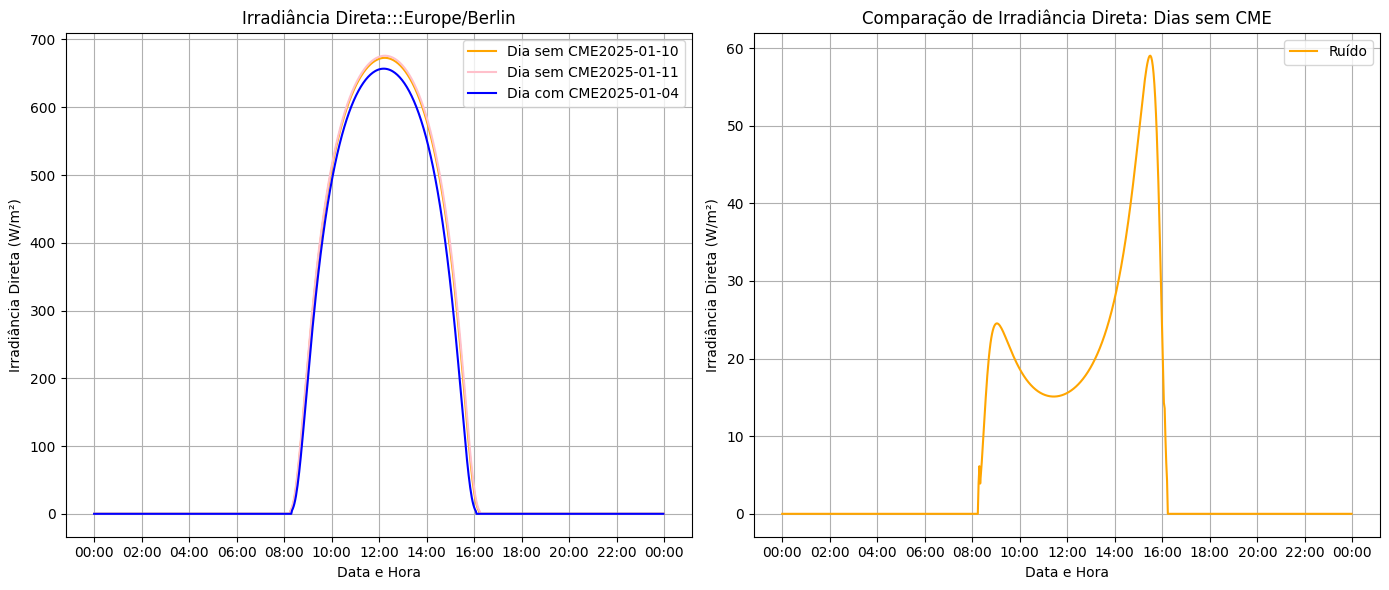

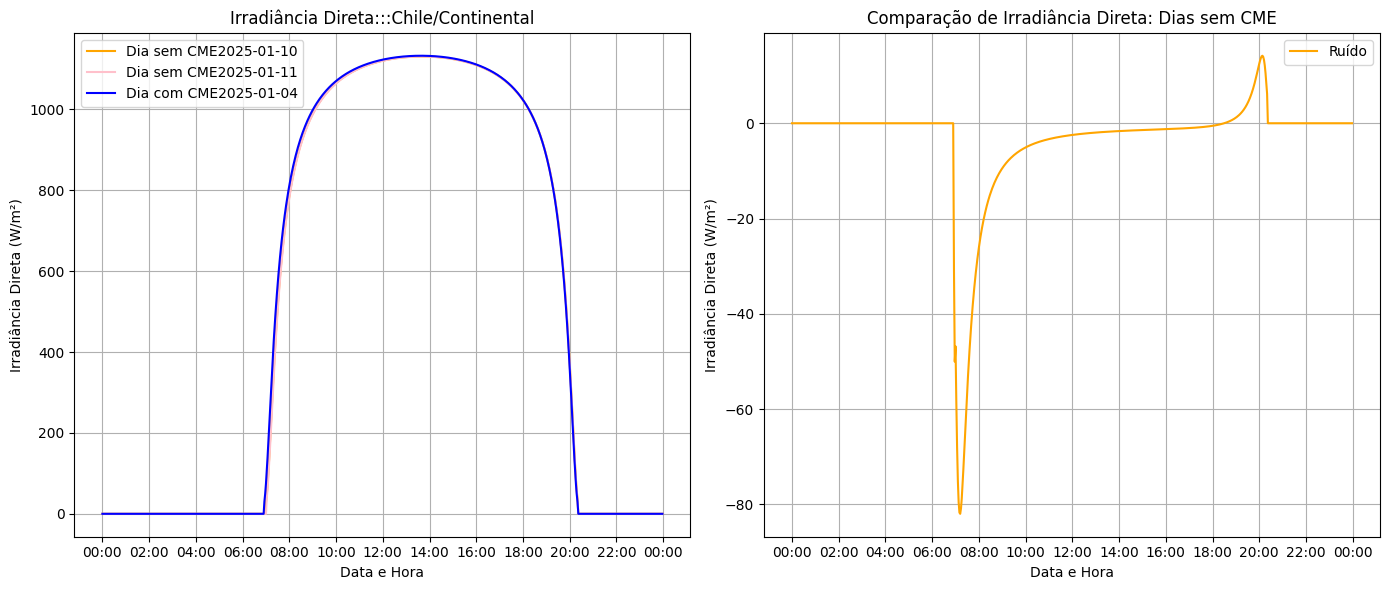

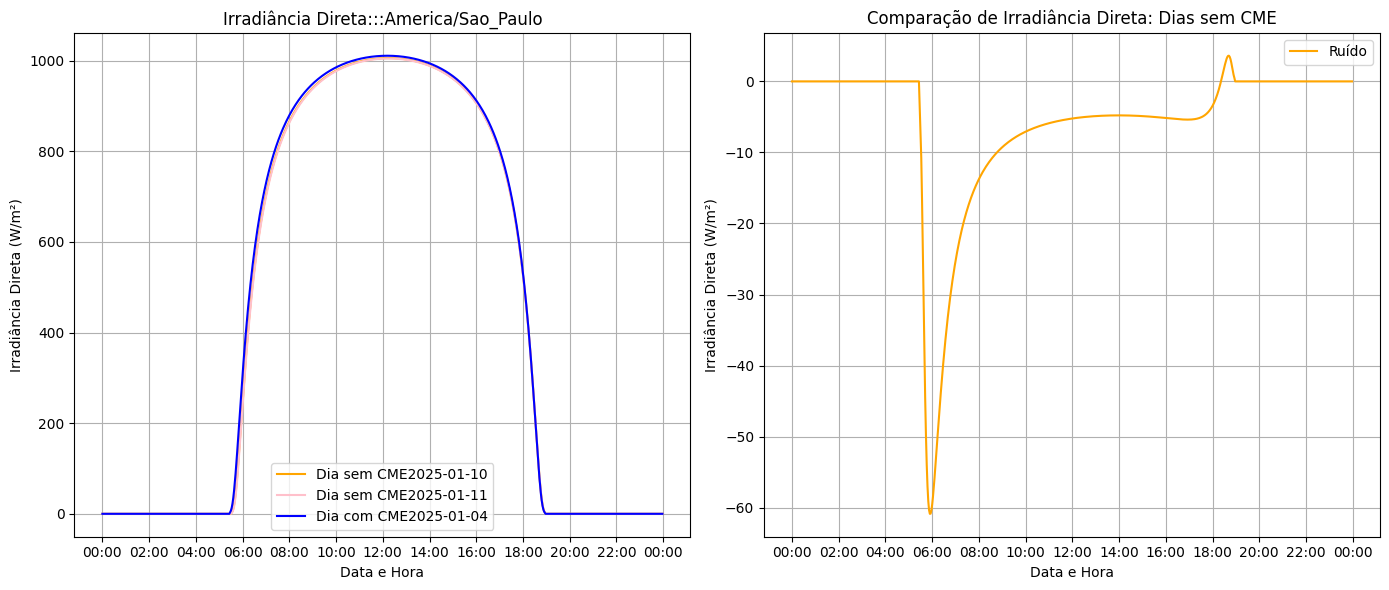

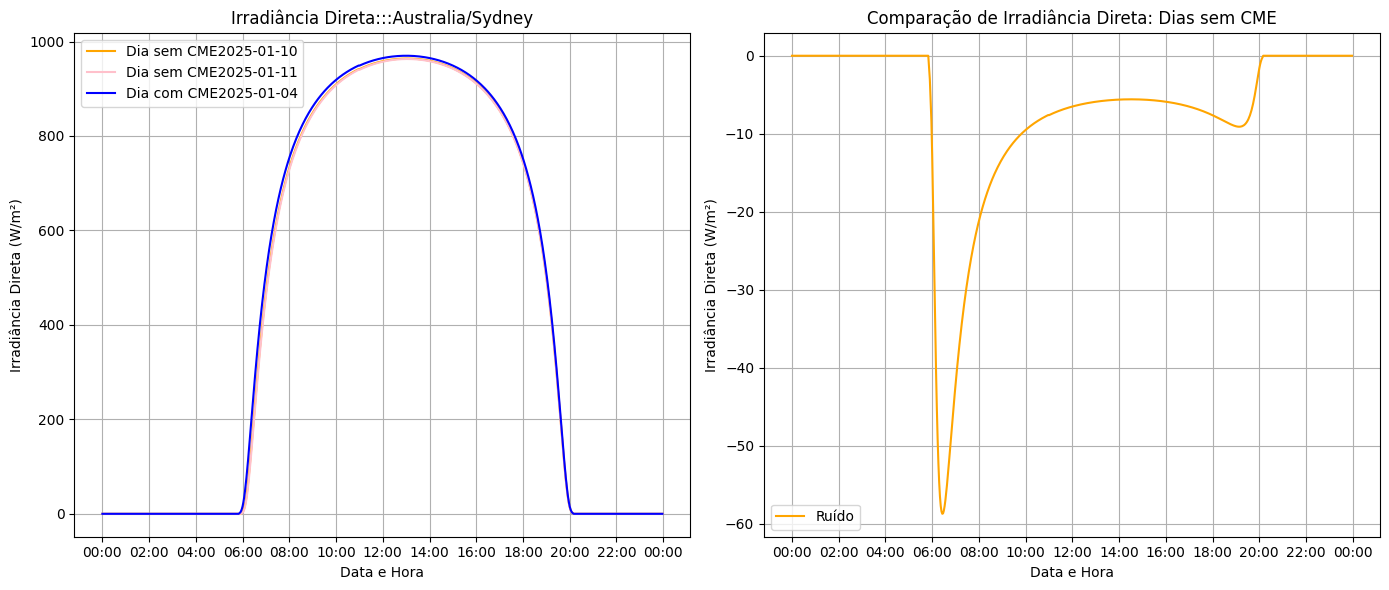

In [188]:
# Localização e dados meteorológicos

campo = Amostras()
# Hem norte
campo.addAmostra(Zone(40.7128, -74.0060, 'America/New_York')) # Localização e dados meteorológicos para Nova Iorque
campo.addAmostra(Zone(64.13, -21.90, 'Atlantic/Reykjavik')) # Localização e dados meteorológicos para a Islândia
campo.addAmostra(Zone( 60.17, 24.94, 'Europe/Helsinki'))  # Localização e dados meteorológicos para a Finlândia
campo.addAmostra(Zone(51.5074, -0.1278, 'Europe/London')) # Localização e dados meteorológicos para o Reino Unido
campo.addAmostra(Zone(52.5200, 13.4050, 'Europe/Berlin')) # Localização e dados meteorológicos para Berlin
# Hem sul
campo.addAmostra(Zone(-22.9068, -68.2019, 'Chile/Continental')) # Localização e dados meteorológicos para San Pedro de Atacama, Chile
campo.addAmostra(Zone(-23.55, -46.63, 'America/Sao_Paulo')) # Localização e dados meteorológicos para São Paulo
campo.addAmostra(Zone(-33.8688, 151.2093, 'Australia/Sydney')) # Localização e dados meteorológicos para Sydney


campo.setupCmeDates("2025-01-04", "2025-01-04 23:59")
campo.setupNoCmeDates("2025-01-10","2025-01-10 23:59")
campo.setupSecondaryNoCmeDates("2025-01-11","2025-01-11 23:59")

calcSunCurves(campo)

# Cme 12/06/2021 | Média

A erupção solar de 12 de junho de 2021 foi uma erupção classe M, o que indica uma explosão solar de média intensidade. Para eventos dessa classe, a energia liberada é tipicamente enorme, mas não chega a ser tão intensa quanto as erupções classe X.

Embora a energia exata da erupção de 12 de junho de 2021 não seja facilmente encontrada em fontes de acesso público, podemos estimar com base em dados típicos de erupções solares.

Estimativas de Energia para Erupções de Classe M:
As erupções solares classe M podem liberar uma energia equivalente a 10^25 joules ou até mais

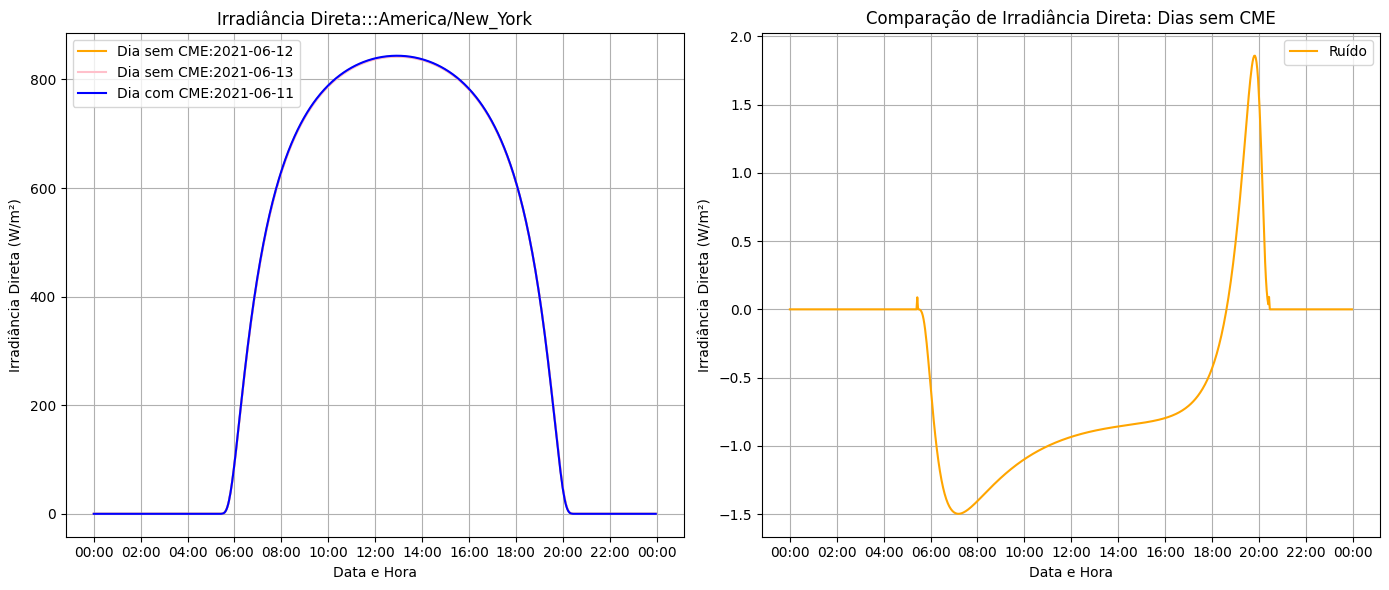

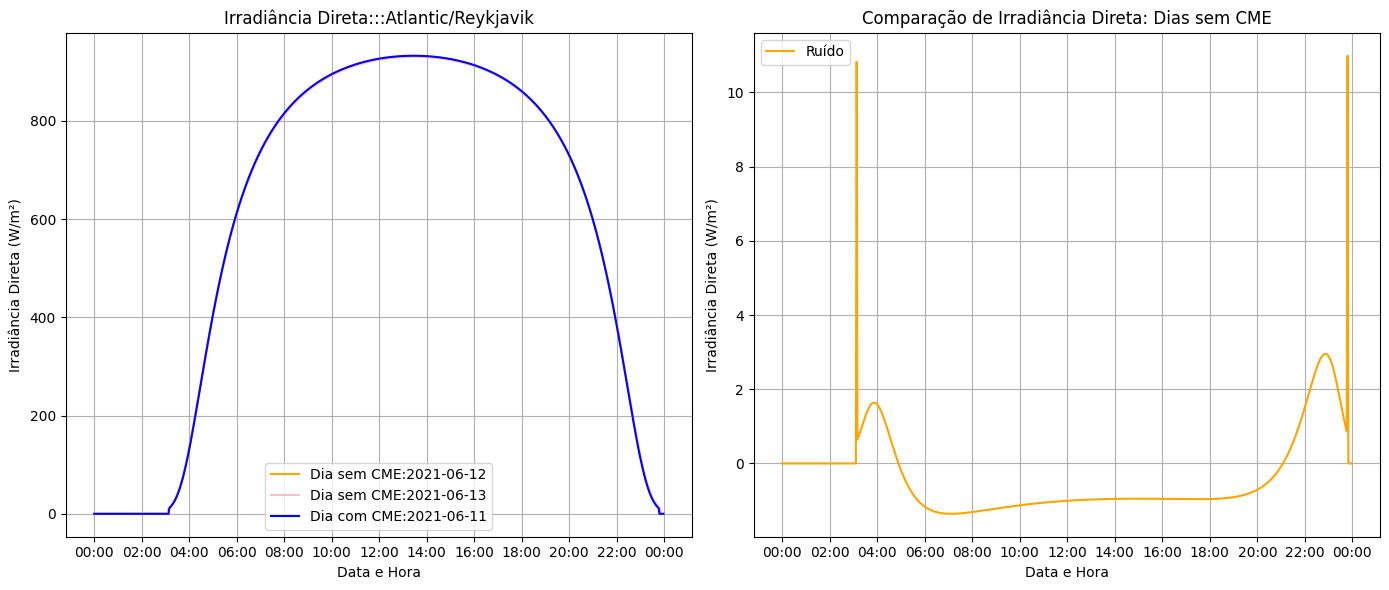

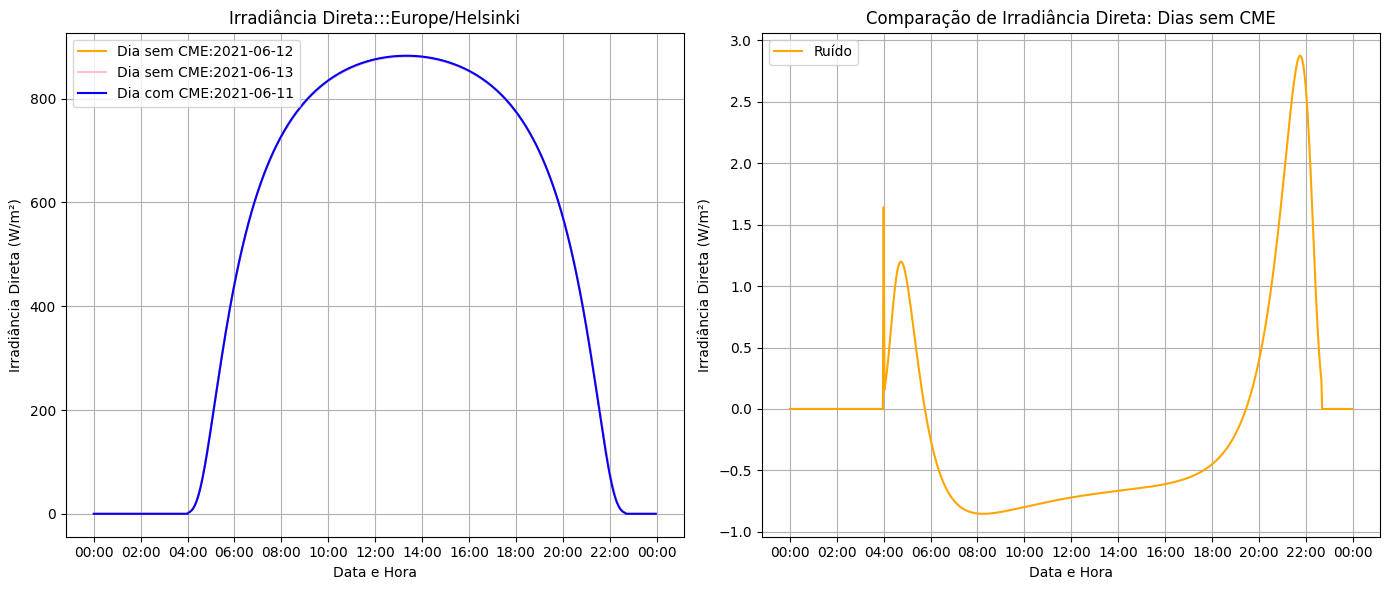

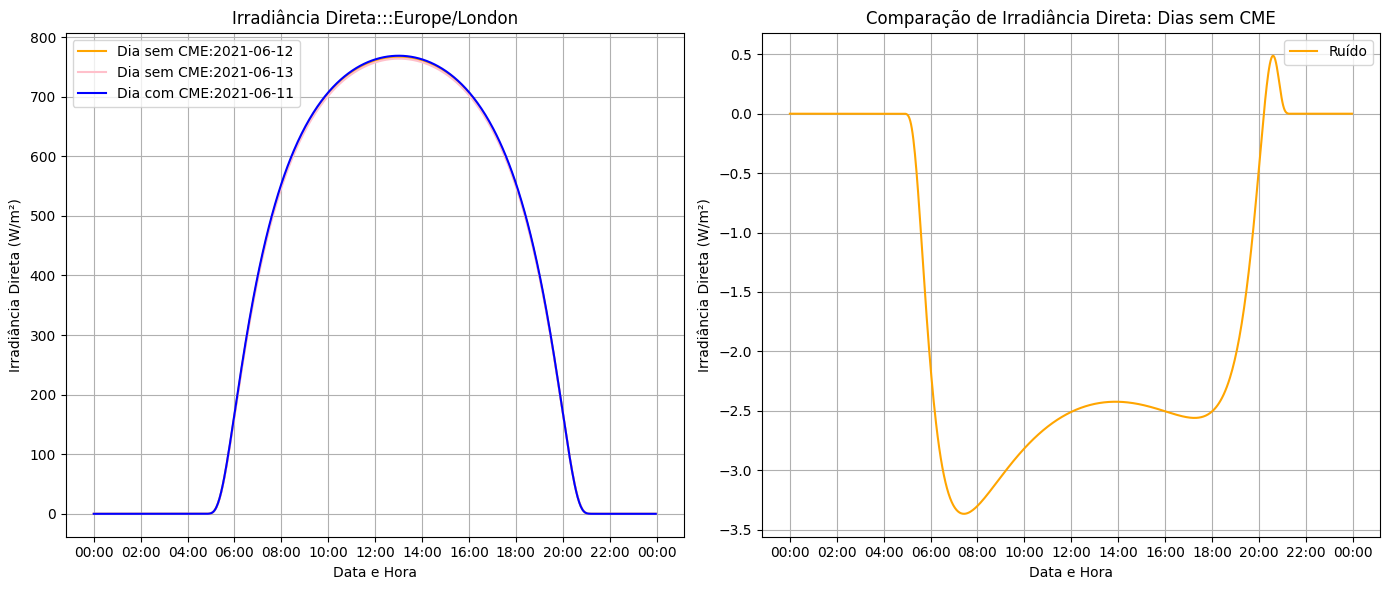

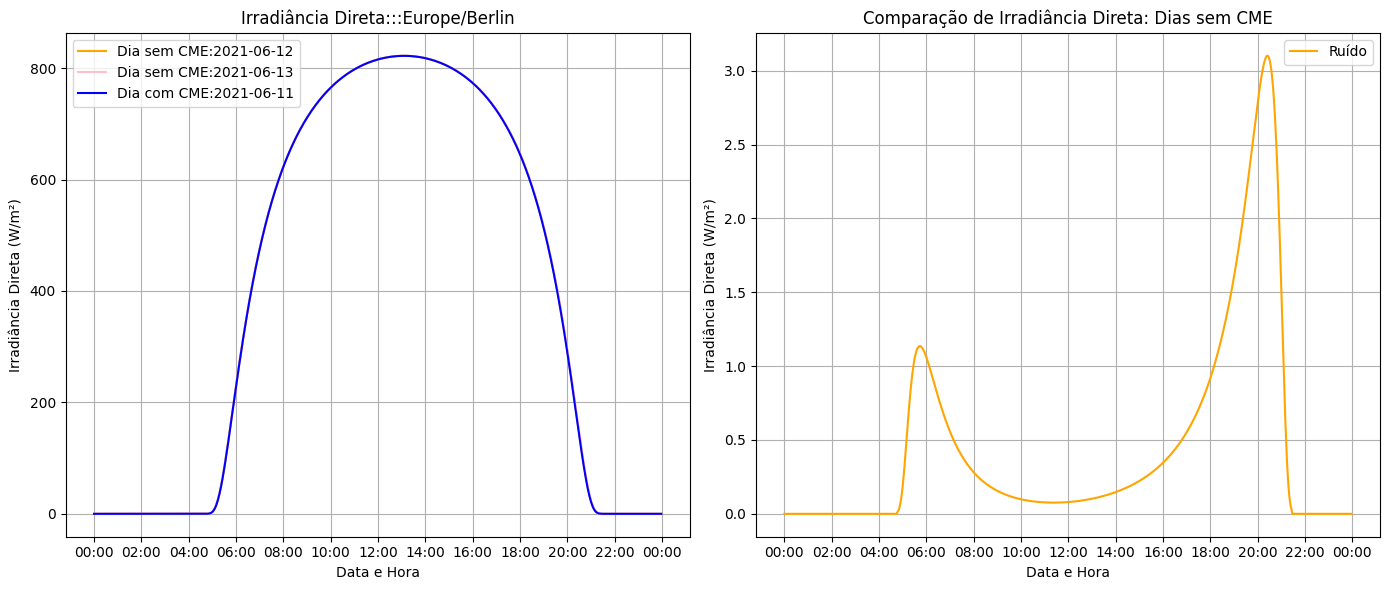

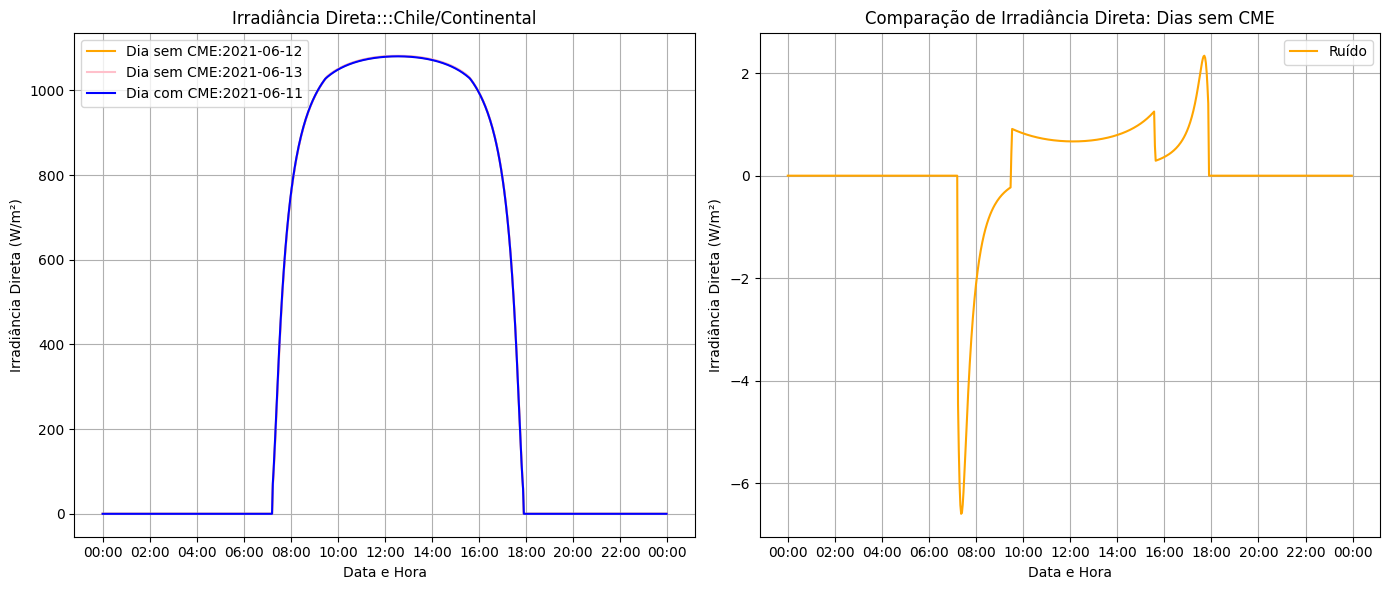

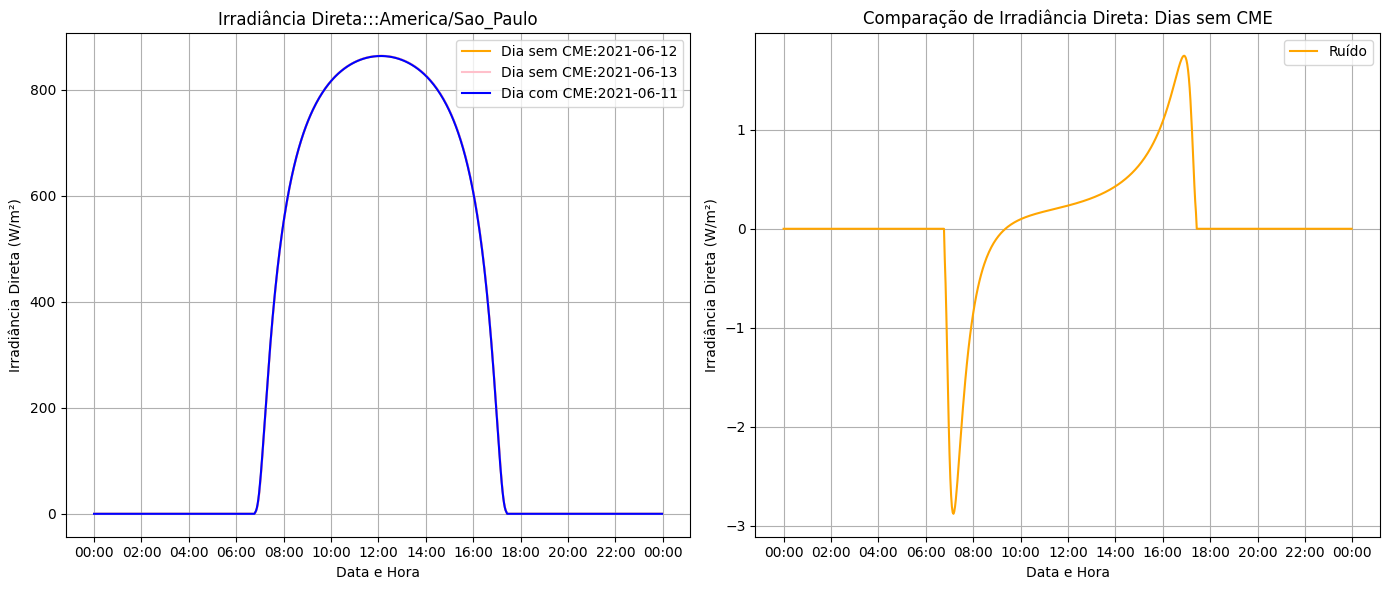

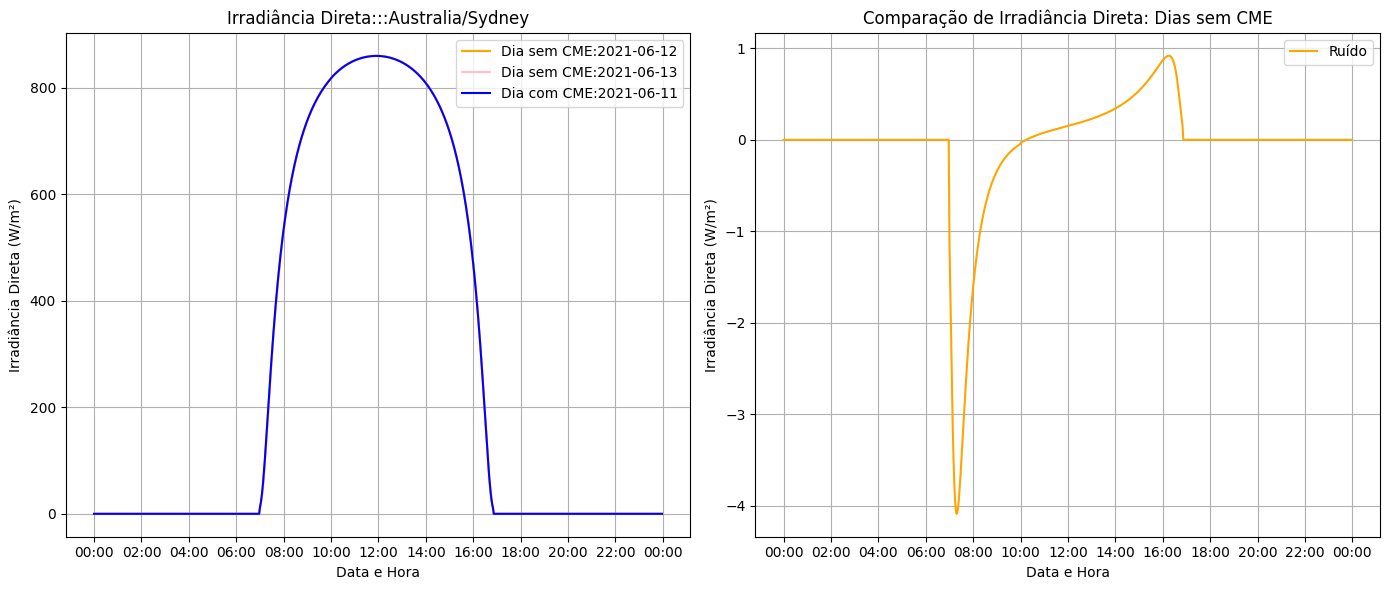

In [190]:
# Localização e dados meteorológicos

campo = Amostras()
# Hem norte
campo.addAmostra(Zone(40.7128, -74.0060, 'America/New_York')) # Localização e dados meteorológicos para Nova Iorque
campo.addAmostra(Zone(64.13, -21.90, 'Atlantic/Reykjavik')) # Localização e dados meteorológicos para a Islândia
campo.addAmostra(Zone( 60.17, 24.94, 'Europe/Helsinki'))  # Localização e dados meteorológicos para a Finlândia
campo.addAmostra(Zone(51.5074, -0.1278, 'Europe/London')) # Localização e dados meteorológicos para o Reino Unido
campo.addAmostra(Zone(52.5200, 13.4050, 'Europe/Berlin')) # Localização e dados meteorológicos para Berlin
# Hem sul
campo.addAmostra(Zone(-22.9068, -68.2019, 'Chile/Continental')) # Localização e dados meteorológicos para San Pedro de Atacama, Chile
campo.addAmostra(Zone(-23.55, -46.63, 'America/Sao_Paulo')) # Localização e dados meteorológicos para São Paulo
campo.addAmostra(Zone(-33.8688, 151.2093, 'Australia/Sydney')) # Localização e dados meteorológicos para Sydney

campo.setupCmeDates("2021-06-11", "2021-06-11 23:59")
campo.setupNoCmeDates("2021-06-12","2021-06-12 23:59")
campo.setupSecondaryNoCmeDates("2021-06-13","2021-06-13 23:59")

calcSunCurves(campo)


# CME 04/01/2025 | Alta

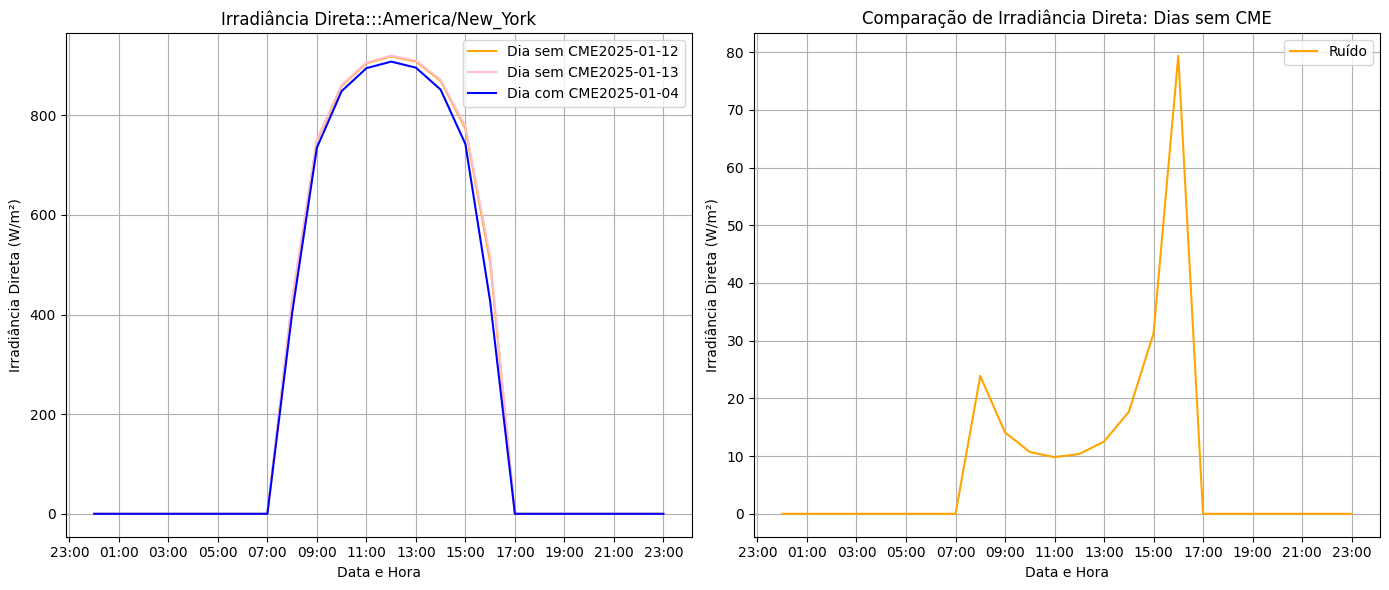

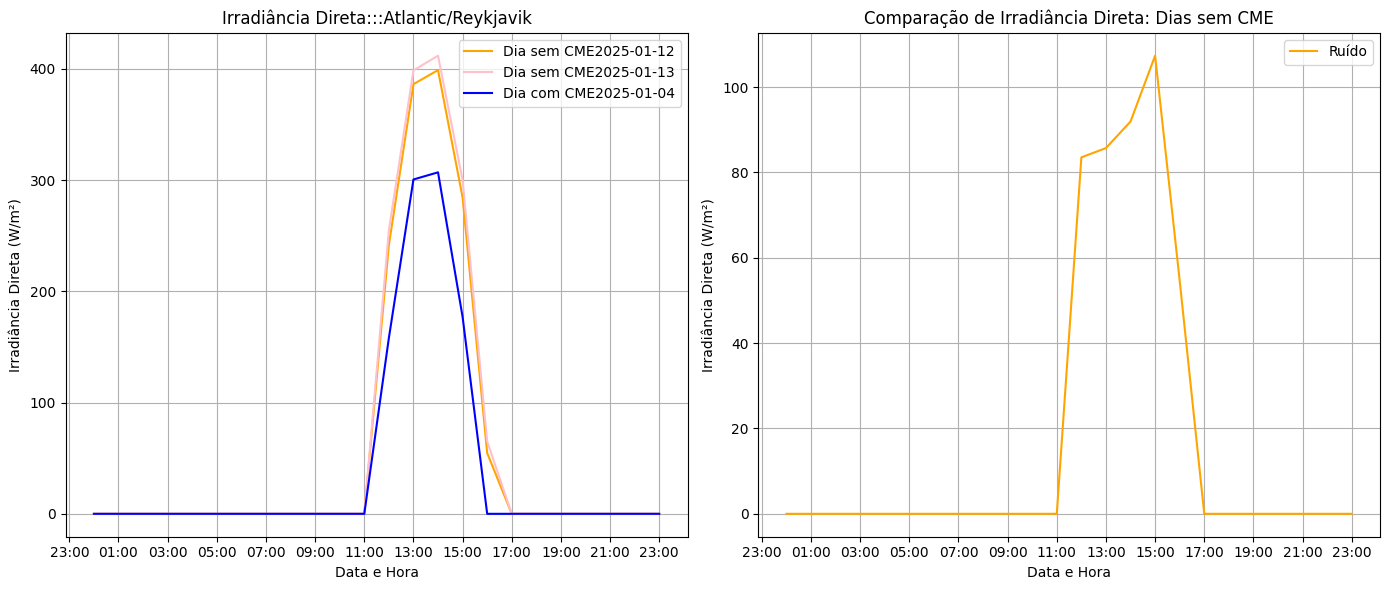

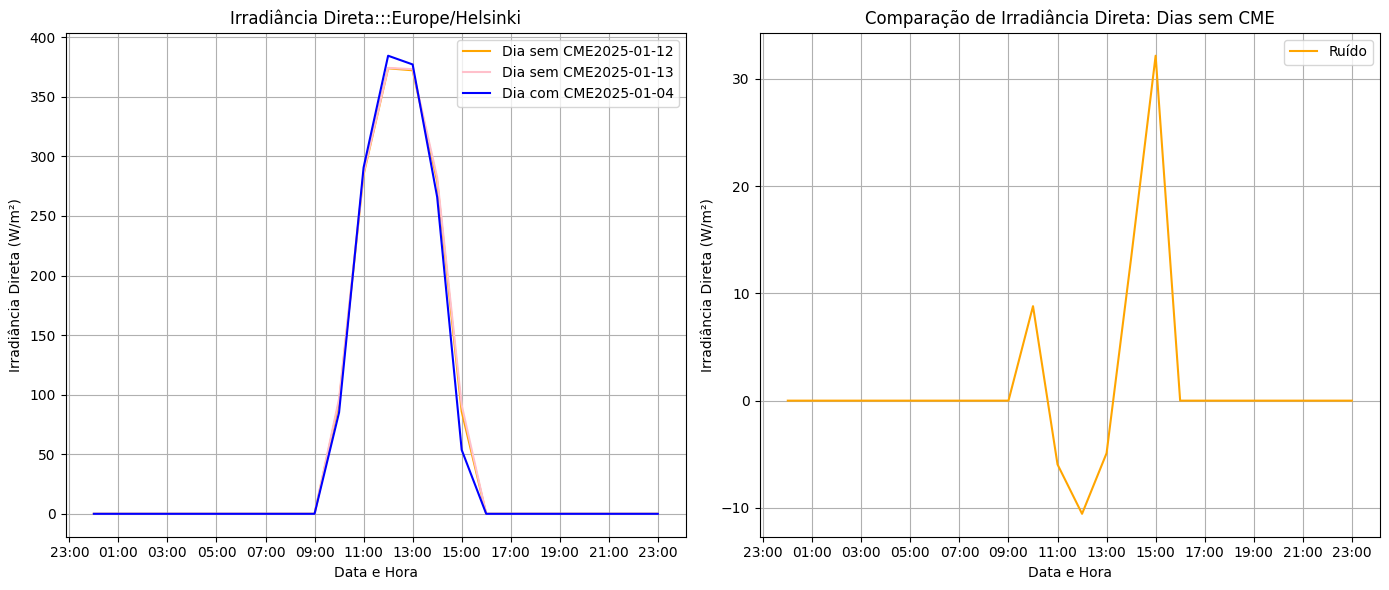

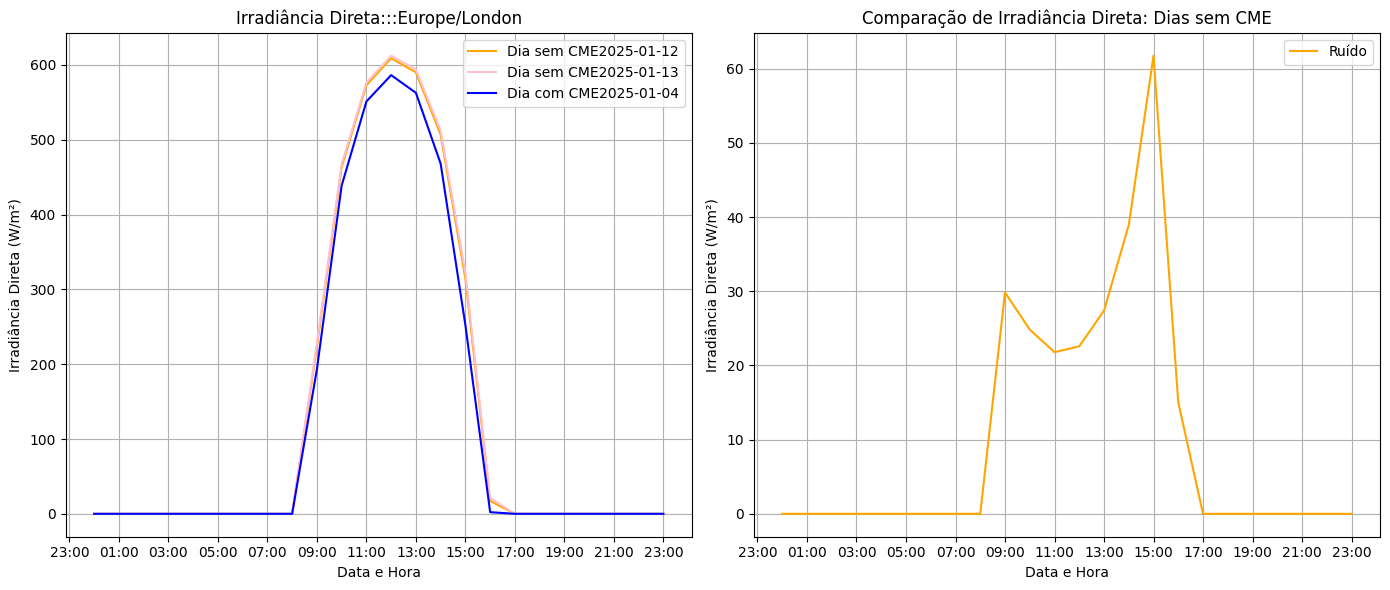

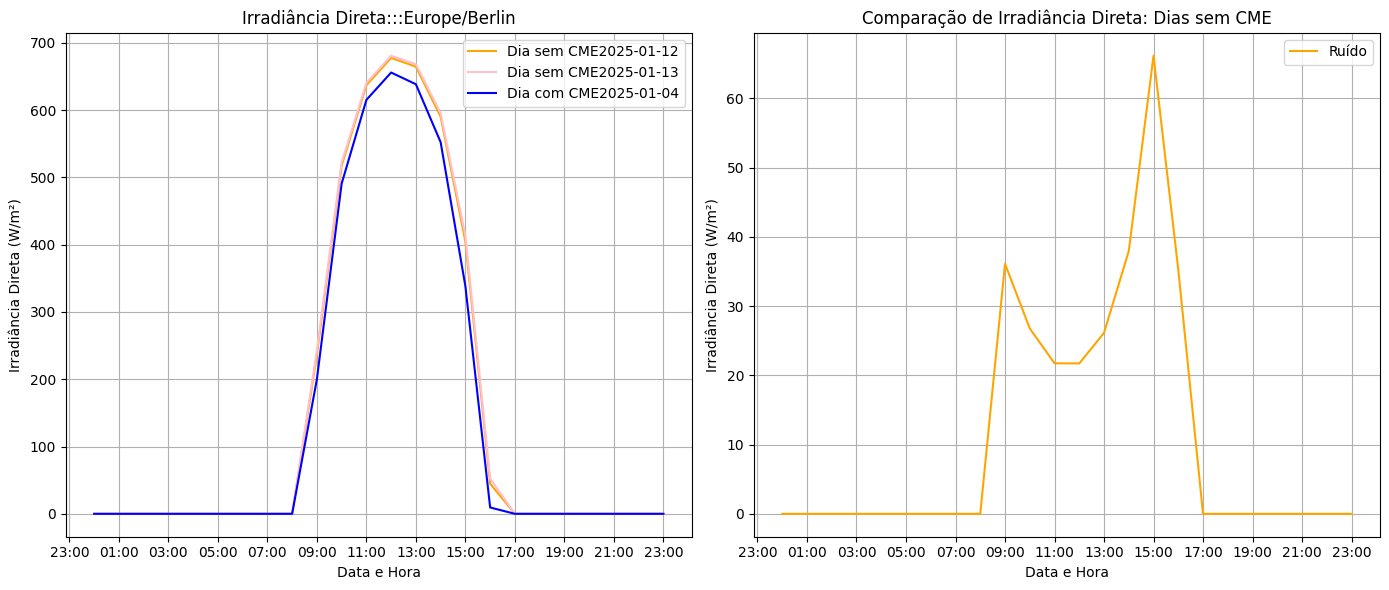

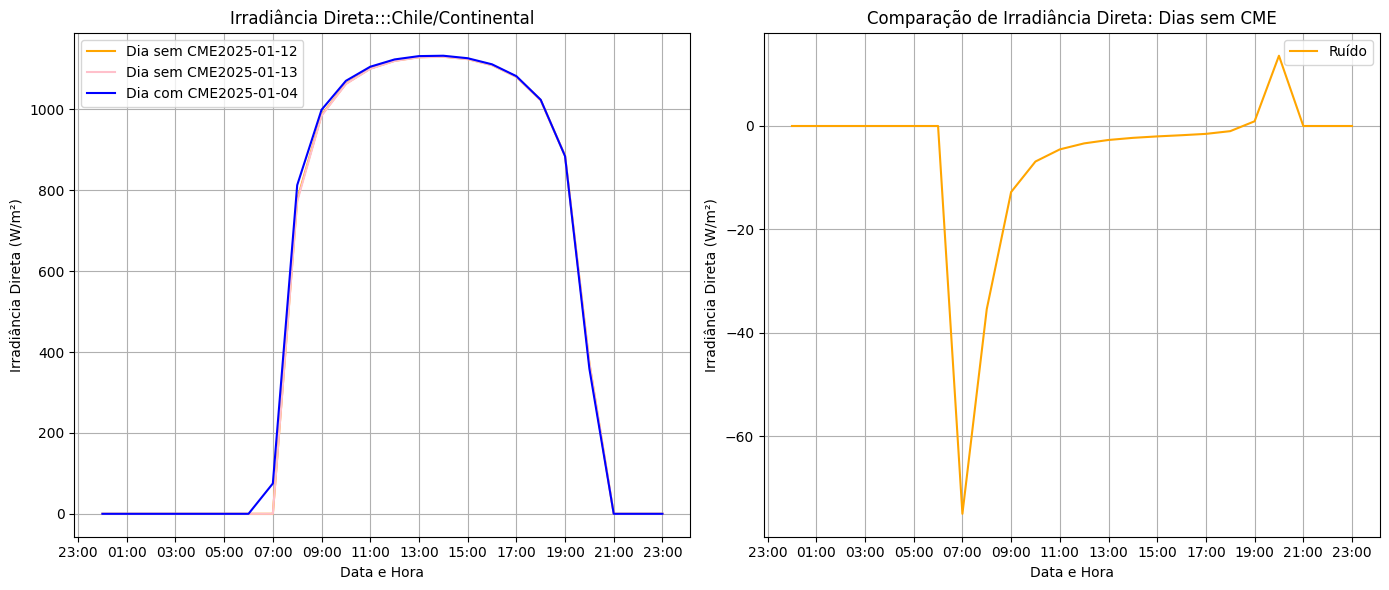

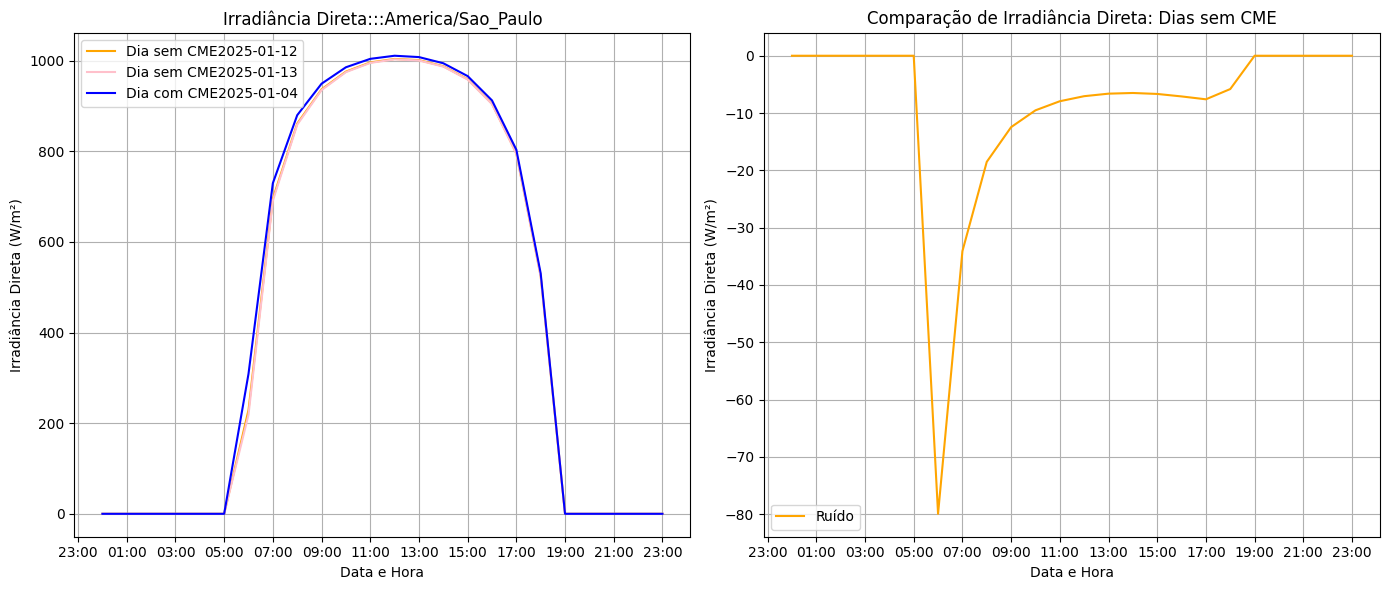

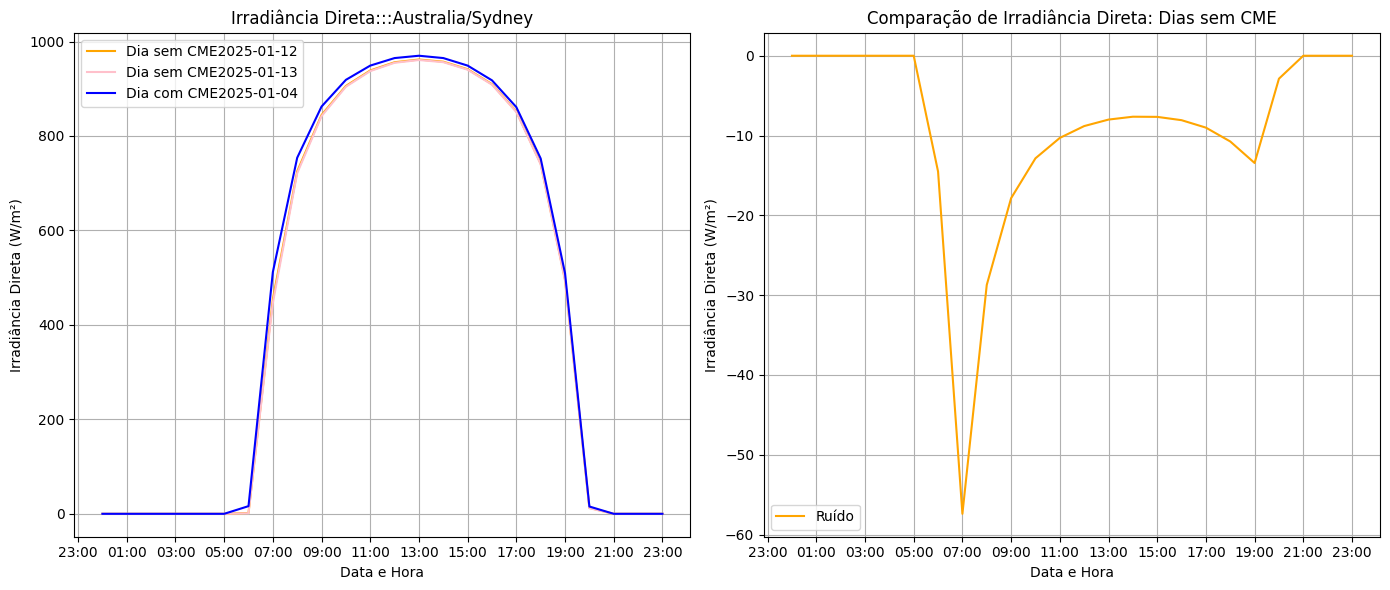

In [184]:
# Localização e dados meteorológicos

campo = Amostras()
# Hem norte
campo.addAmostra(Zone(40.7128, -74.0060, 'America/New_York')) # Localização e dados meteorológicos para Nova Iorque
campo.addAmostra(Zone(64.13, -21.90, 'Atlantic/Reykjavik')) # Localização e dados meteorológicos para a Islândia
campo.addAmostra(Zone( 60.17, 24.94, 'Europe/Helsinki'))  # Localização e dados meteorológicos para a Finlândia
campo.addAmostra(Zone(51.5074, -0.1278, 'Europe/London')) # Localização e dados meteorológicos para o Reino Unido
campo.addAmostra(Zone(52.5200, 13.4050, 'Europe/Berlin')) # Localização e dados meteorológicos para Berlin
# Hem sul
campo.addAmostra(Zone(-22.9068, -68.2019, 'Chile/Continental')) # Localização e dados meteorológicos para San Pedro de Atacama, Chile
campo.addAmostra(Zone(-23.55, -46.63, 'America/Sao_Paulo')) # Localização e dados meteorológicos para São Paulo
campo.addAmostra(Zone(-33.8688, 151.2093, 'Australia/Sydney')) # Localização e dados meteorológicos para Sydney

campo.setupCmeDates("2025-01-04", "2025-01-04 23:59")
campo.setupNoCmeDates("2025-01-12","2025-01-12 23:59")
campo.setupSecondaryNoCmeDates("2025-01-13","2025-01-13 23:59")

calcSunCurves(campo)

# CME 24/10/2024 com aurora boreal 

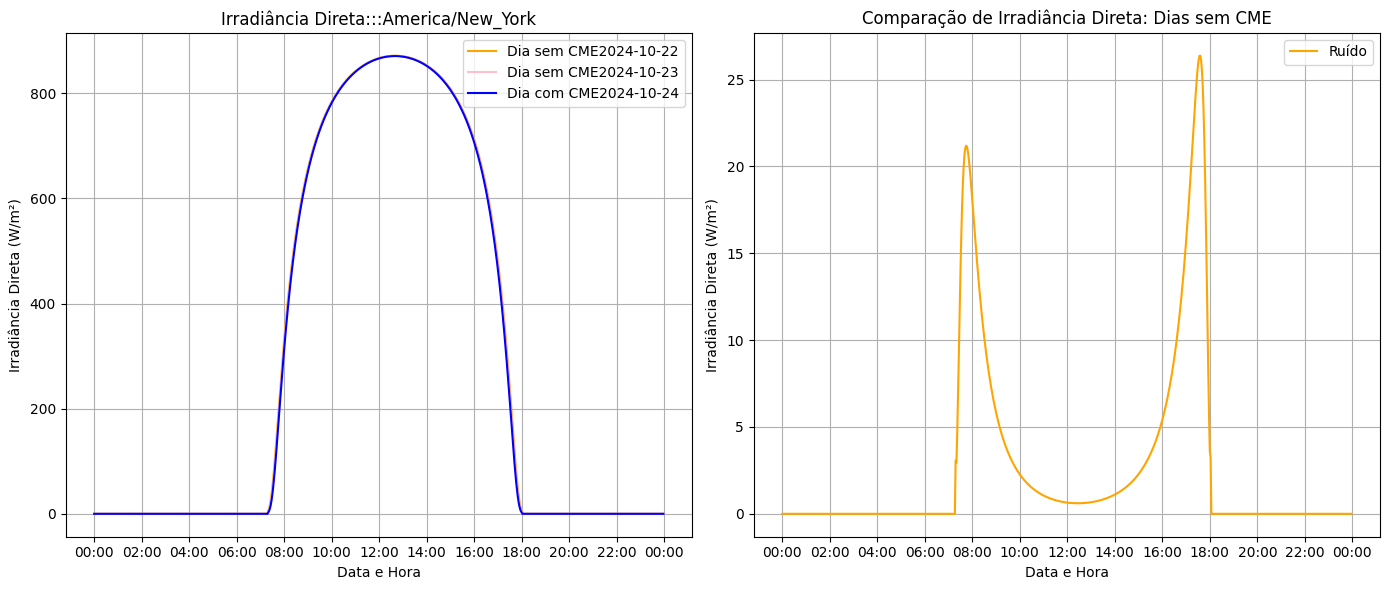

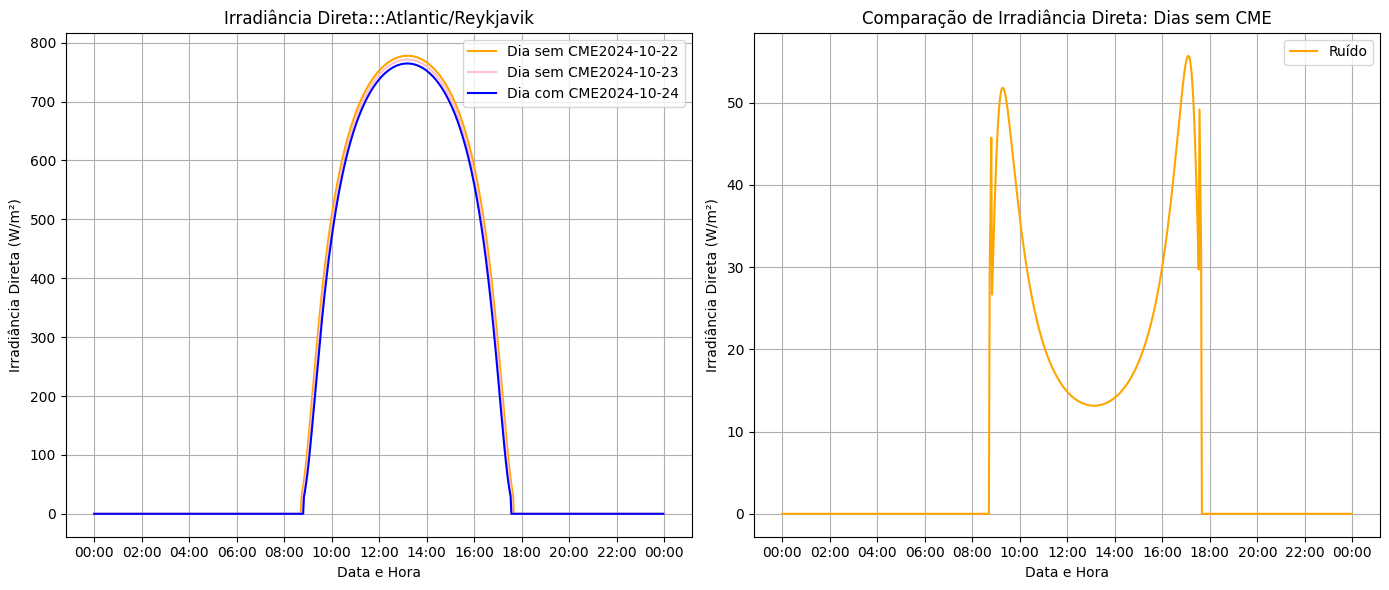

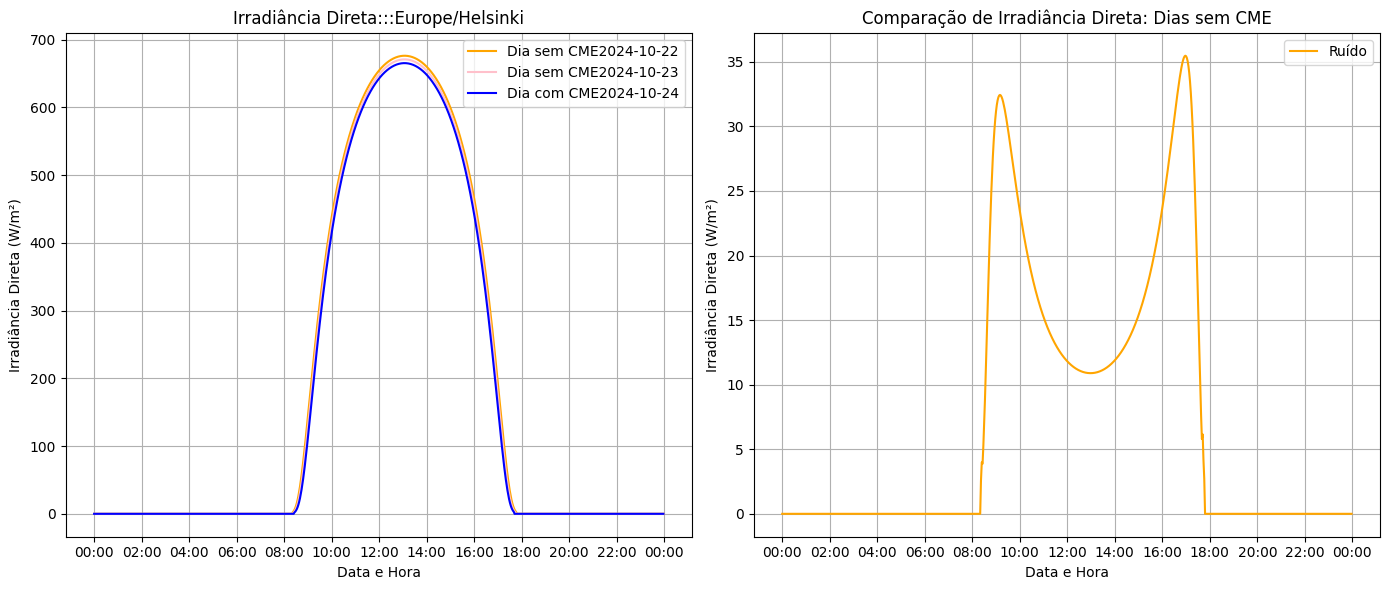

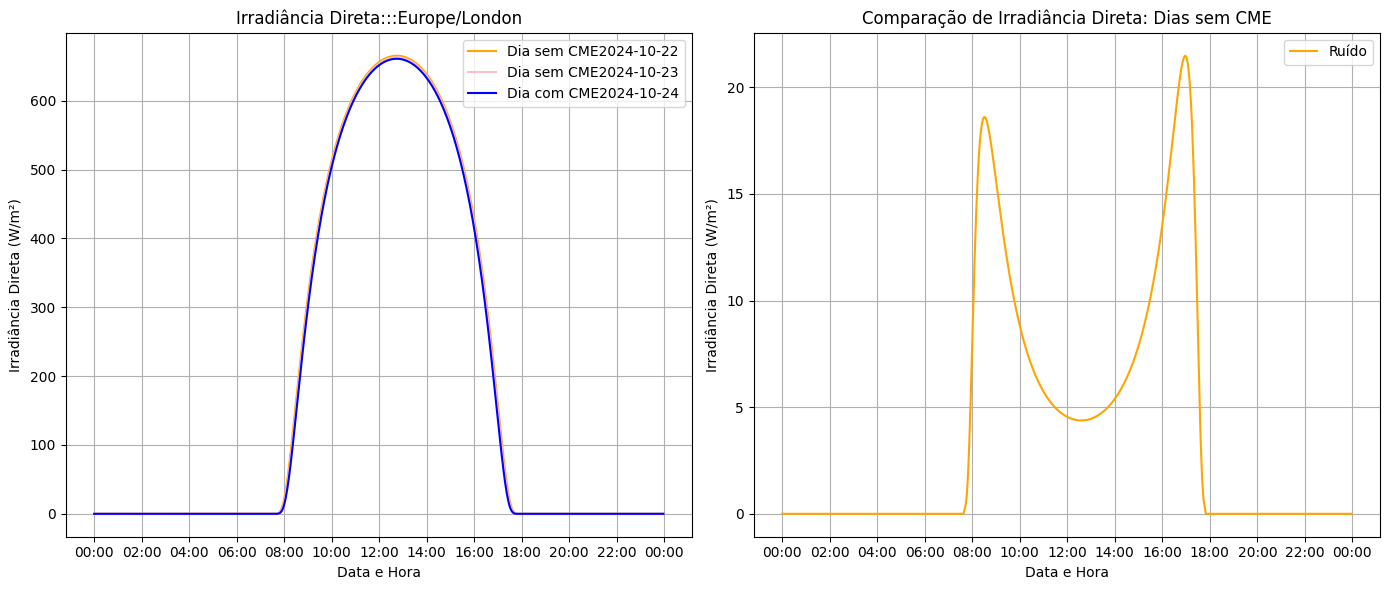

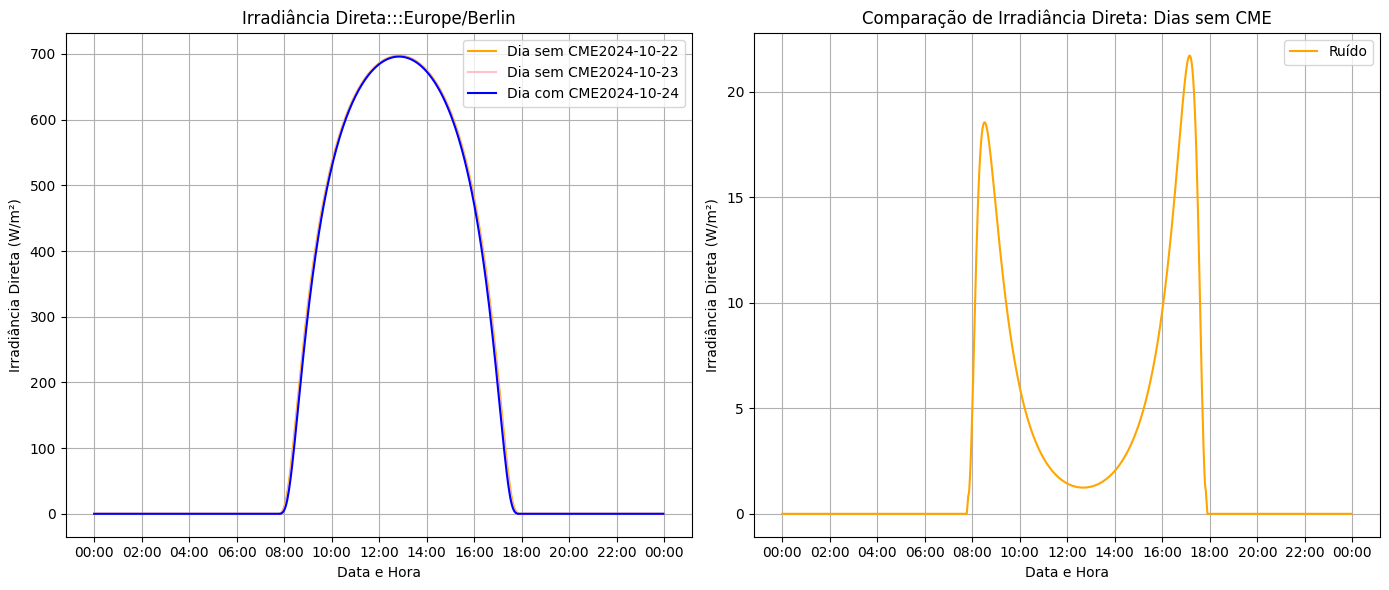

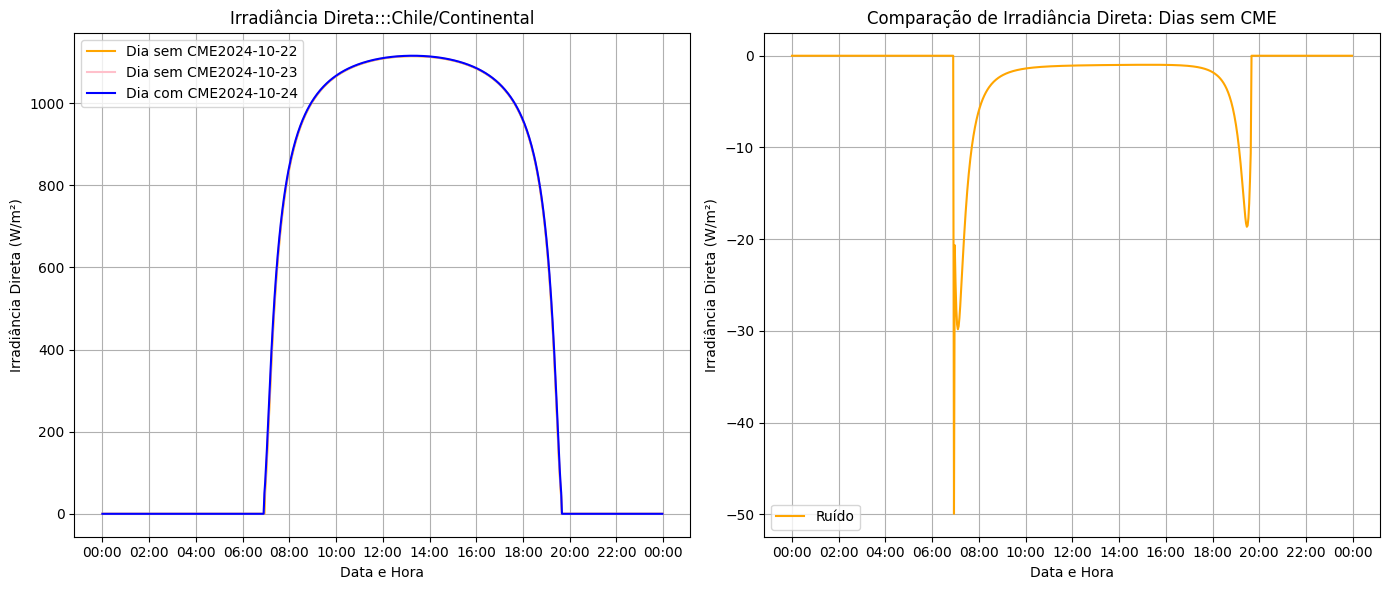

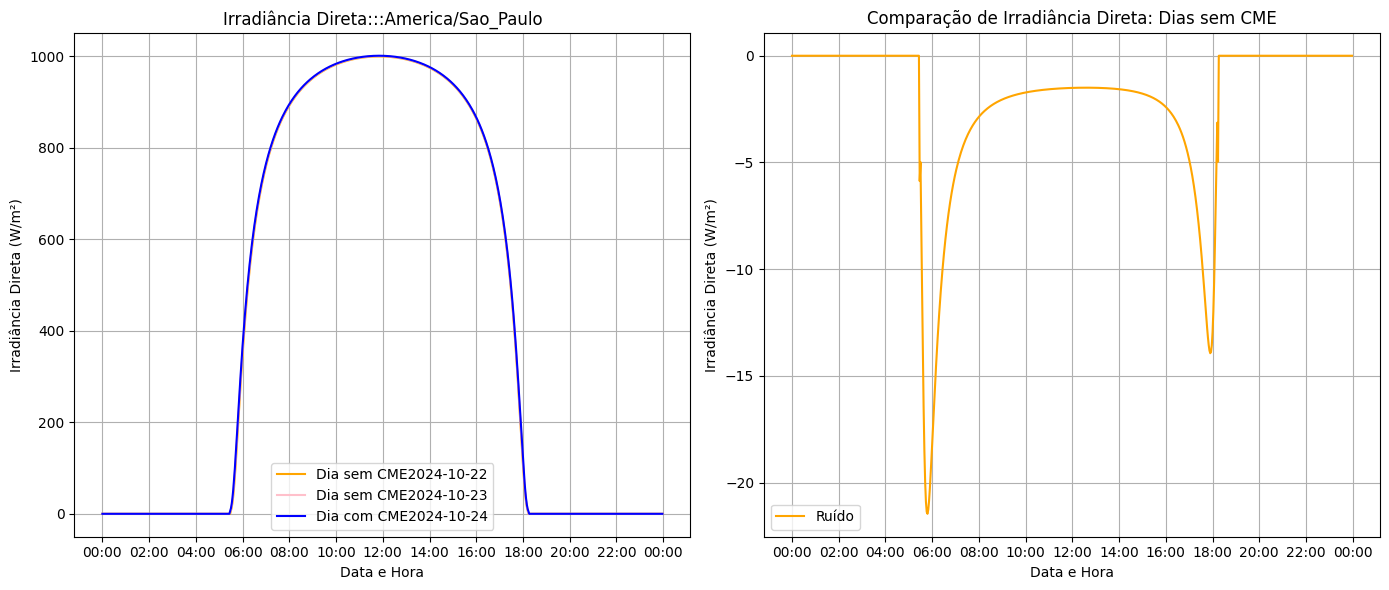

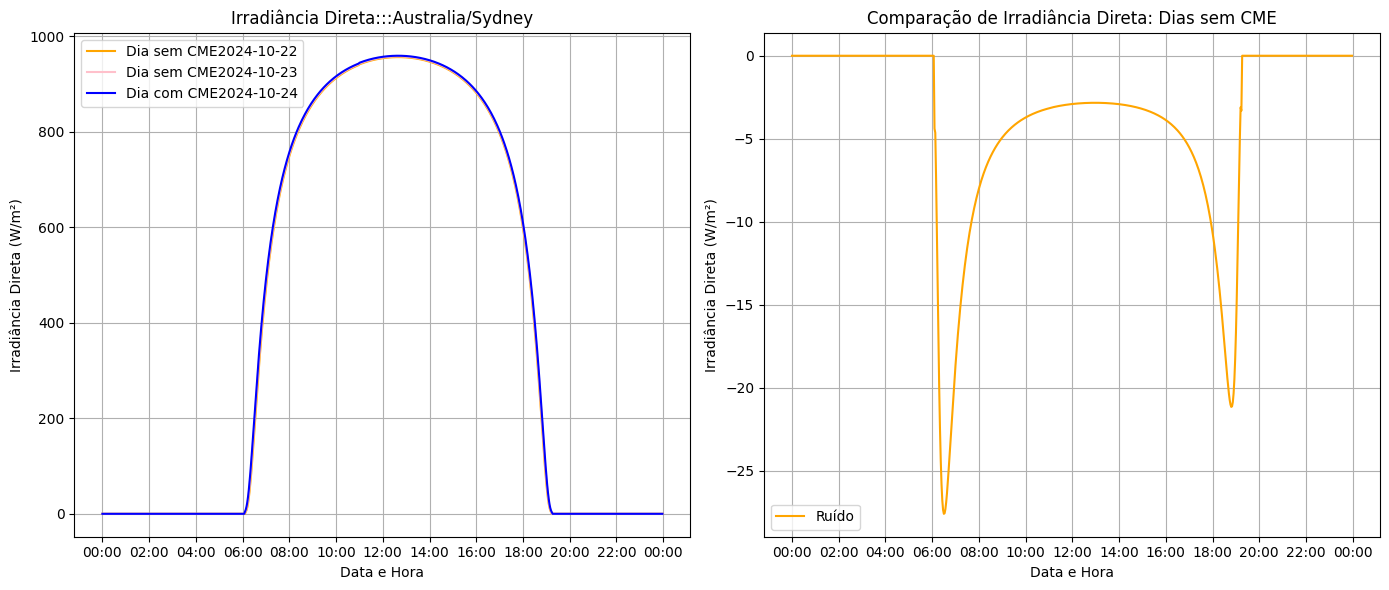

In [187]:
# Localização e dados meteorológicos
campo = Amostras()

# Hem norte
campo.addAmostra(Zone(40.7128, -74.0060, 'America/New_York')) # Localização e dados meteorológicos para Nova Iorque
campo.addAmostra(Zone(64.13, -21.90, 'Atlantic/Reykjavik')) # Localização e dados meteorológicos para a Islândia
campo.addAmostra(Zone( 60.17, 24.94, 'Europe/Helsinki'))  # Localização e dados meteorológicos para a Finlândia
campo.addAmostra(Zone(51.5074, -0.1278, 'Europe/London')) # Localização e dados meteorológicos para o Reino Unido
campo.addAmostra(Zone(52.5200, 13.4050, 'Europe/Berlin')) # Localização e dados meteorológicos para Berlin
# Hem sul
campo.addAmostra(Zone(-22.9068, -68.2019, 'Chile/Continental')) # Localização e dados meteorológicos para San Pedro de Atacama, Chile
campo.addAmostra(Zone(-23.55, -46.63, 'America/Sao_Paulo')) # Localização e dados meteorológicos para São Paulo
campo.addAmostra(Zone(-33.8688, 151.2093, 'Australia/Sydney')) # Localização e dados meteorológicos para Sydney

campo.setupCmeDates("2024-10-24", "2024-10-24 23:59")
campo.setupNoCmeDates("2024-10-22","2024-10-22 23:59")
campo.setupSecondaryNoCmeDates("2024-10-23","2024-10-23 23:59")

calcSunCurves(campo)